### Importing packages

In [1]:
# Libraries

# Reading in files
import pandas as pd
import numpy as np

import spacy
import scipy.sparse as sp
from nltk.stem.snowball import SnowballStemmer

from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import normalize
from sklearn.metrics import classification_report

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

from keybert import KeyBERT
from flair.embeddings import TransformerDocumentEmbeddings

import yake

import sys
import time

from tqdm import tqdm

tqdm.pandas()

In [2]:
pd.options.display.max_colwidth = 5000

### Reading in data

In [1273]:
df_ACL_2020 = pd.read_csv("./Data/Pred/BART/ACL_2022_bart_pred_231122.csv")
df_EMNLP_2020 = pd.read_csv("./Data/Pred/BART/EMNLP_2020_bart_pred_231122.csv")

df_ACL_2020 = df_ACL_2020[["Labels", "Paper Name", "abstract"]]
df_EMNLP_2020 = df_EMNLP_2020[["Labels", "Paper Name", "abstract"]]

df_ACL_2020.columns = ["Label", "Title", "Abstract"]
df_EMNLP_2020.columns = ["Label", "Title", "Abstract"]

df_ACL_2020 = df_ACL_2020.loc[lambda df_ACL_2020: ~df_ACL_2020["Label"].isin(["Student Research Workshop", "Theme", "NLP Applications", "System Demonstrations"]), :]
df_ACL_2020["Label"].unique()


df_ACL_2020

,Label,Title,Abstract
0,"Linguistic Theories, Cognitive Modeling and Psycholinguistics",Overestimation of Syntactic Representation in Neural Language Models,"With the advent of powerful neural language models over the last few years, research attention has increasingly focused on what aspects of language they represent that make them so successful. Several testing methodologies have been developed to probe models' syntactic representations. One popular method for determining a model's ability to induce syntactic structure trains a model on strings generated according to a template then tests the model's ability to distinguish such strings from superficially similar ones with different syntax. We illustrate a fundamental problem with this approach by reproducing positive results from a recent paper with two non-syntactic baseline language models: an n-gram model and an LSTM model trained on scrambled inputs."
1,"Linguistic Theories, Cognitive Modeling and Psycholinguistics",Inflecting When There's No Majority: Limitations of Encoder-Decoder Neural Networks as Cognitive Models for German Plurals,"Can artificial neural networks learn to represent inflectional morphology and generalize to new words as human speakers do? Kirov and Cotterell (2018) argue that the answer is yes: modern Encoder-Decoder (ED) architectures learn human-like behavior when inflecting English verbs, such as extending the regular past tense form /-(e)d/ to novel words. However, their work does not address the criticism raised by Marcus et al. (1995) : that neural models may learn to extend not the regular, but the most frequent class -and thus fail on tasks like German number inflection, where infrequent suffixes like /-s/ can still be productively generalized. To investigate this question, we first collect a new dataset from German speakers (production and ratings of plural forms for novel nouns) that is designed to avoid sources of information unavailable to the ED model. The speaker data show high variability, and two suffixes evince 'regular' behavior, appearing more often with phonologically atypical inputs. Encoder-decoder models do generalize the most frequently produced plural class, but do not show human-like variability or 'regular' extension of these other plural markers. We conclude that modern neural models may still struggle with minority-class generalization."
2,"Linguistic Theories, Cognitive Modeling and Psycholinguistics",A Systematic Assessment of Syntactic Generalization in Neural Language Models,"While state-of-the-art neural network models continue to achieve lower perplexity scores on language modeling benchmarks, it remains unknown whether optimizing for broad-coverage predictive performance leads to human-like syntactic knowledge. Furthermore, existing work has not provided a clear picture about the model properties required to produce proper syntactic generalizations. We present a systematic evaluation of the syntactic knowledge of neural language models, testing 20 combinations of model types and data sizes on a set of 34 English-language syntactic test suites. We find substantial differences in syntactic generalization performance by model architecture, with sequential models underperforming other architectures. Factorially manipulating model architecture and training dataset size (1M-40M words), we find that variability in syntactic generalization performance is substantially greater by architecture than by dataset size for the corpora tested in our experiments. Our results also reveal a dissociation between perplexity and syntactic generalization performance."
3,"Linguistic Theories, Cognitive Modeling and Psycholinguistics",Predicting Depression in Screening Interviews from Latent Categorization of Interview Prompts,"Despite the pervasiveness of clinical depression in modern society, professional help remains highly stigmatized, inaccessible, and expensive. Accurately diagnosing depression is difficult-requiring time-intensive 

In [1277]:
df_EMNLP_2020 = df_EMNLP_2020.loc[lambda df_EMNLP_2020: ~df_EMNLP_2020["Label"].isin(["Student Research Workshop", "Theme", "NLP Applications", "System Demonstrations"]), :]

In [1274]:
df_ACL_2020['Text'] = df_ACL_2020['Title'] + " " +df_ACL_2020['Abstract']
df_EMNLP_2020['Text'] = df_EMNLP_2020['Title'] + " " +df_EMNLP_2020['Abstract']

nlp = spacy.load('en_core_web_trf', disable=['parser', 'ner'])
stemmer = SnowballStemmer("english")

def lemmatiser_stemmer_stopword(text, nlp, stemmer):
    
    doc = nlp(text)
    lemmatised_sentence_lst = [token.lemma_ for token in doc if not token.is_stop]
    lemmatised_sentence = " ".join(lemmatised_sentence_lst)
    stemmed_lemmatised_sentence = stemmer.stem(lemmatised_sentence)
    
    return stemmed_lemmatised_sentence.lower()

In [1275]:
df_ACL_2020['Lemm Stemmed Text'] = df_ACL_2020['Text'].progress_apply(lemmatiser_stemmer_stopword, args=(nlp, stemmer))

100%|███████████████████████████████████████████████████████████████████████████████████████████| 705/705 [02:05<00:00,  5.64it/s]


In [1276]:
df_EMNLP_2020['Lemm Stemmed Text'] = df_EMNLP_2020['Text'].progress_apply(lemmatiser_stemmer_stopword, args=(nlp, stemmer))

100%|███████████████████████████████████████████████████████████████████████████████████████████| 713/713 [02:06<00:00,  5.65it/s]


In [28]:
df_P20 = pd.read_csv("./Data/ACL_2020.csv")
df_D20 = pd.read_csv("./Data/EMNLP_2020.csv")
df_E21 = pd.read_csv("./Data/EACL_2021.csv")
df_P21 = pd.read_csv("./Data/ACL_JCNLP_2021.csv")
df_N21 = pd.read_csv("./Data/NAACL_2021.csv")

In [29]:
print(len(df_P20) + len(df_D20) + len(df_E21) + len(df_P21) + len(df_N21))
print(len(df_P20), len(df_P20.Labels), len(df_P20.Labels.unique()))
print(len(df_D20), len(df_D20.Labels), len(df_D20.Labels.unique()))
print(len(df_E21), len(df_E21.Labels), len(df_E21.Labels.unique()))
print(len(df_P21), len(df_P21.Labels), len(df_P21.Labels.unique()))
print(len(df_N21), len(df_N21.Labels), len(df_N21.Labels.unique()))

2894
791 791 23
781 781 20
320 320 21
528 528 22
474 474 22


In [30]:
df_P20 = df_P20[df_P20["Labels"] != "NLP Applications"]
df_D20 = df_D20[df_D20["Labels"] != "NLP Applications"]
df_E21 = df_E21[df_E21["Labels"] != "NLP Applications"]
df_P21 = df_P21[df_P21["Labels"] != "NLP Applications"]
df_N21 = df_N21[df_N21["Labels"] != "NLP Applications"]

In [31]:
print(len(df_P20) + len(df_D20) + len(df_E21) + len(df_P21) + len(df_N21))
print(len(df_P20), len(df_P20.Labels), len(df_P20.Labels.unique()))
print(len(df_D20), len(df_D20.Labels), len(df_D20.Labels.unique()))
print(len(df_E21), len(df_E21.Labels), len(df_E21.Labels.unique()))
print(len(df_P21), len(df_P21.Labels), len(df_P21.Labels.unique()))
print(len(df_N21), len(df_N21.Labels), len(df_N21.Labels.unique()))

2705
742 742 22
715 715 19
317 317 20
502 502 21
429 429 21


In [32]:
df_P20

,Labels,Paper Name,Author Names
0,"Linguistic Theories, Cognitive Modeling and Psycholinguistics",Inflecting When There's No Majority: Limitations of Encoder-Decoder Neural Networks as Cognitive Models for German Plurals,"Kate McCurdy, Sharon Goldwater, Adam Lopez"
1,"Linguistic Theories, Cognitive Modeling and Psycholinguistics",Learning to Understand Child-directed and Adult-directed Speech,"Lieke Gelderloos, Grzegorz Chrupała, Afra Alishahi"
2,"Linguistic Theories, Cognitive Modeling and Psycholinguistics",Recurrent Neural Network Language Models Always Learn English-Like Relative Clause Attachment,"Forrest Davis, Marten van Schijndel"
3,"Linguistic Theories, Cognitive Modeling and Psycholinguistics",You Don't Have Time to Read This: An Exploration of Document Reading Time Prediction,"Orion Weller, Jordan Hildebrandt, Ilya Reznik, Christopher Challis, E. Shannon Tass, Quinn Snell, Kevin Seppi"
4,"Linguistic Theories, Cognitive Modeling and Psycholinguistics",Predicting Depression in Screening Interviews from Latent Categorization of Interview Prompts,"Alex Rinaldi, Jean Fox Tree, Snigdha Chaturvedi"
...,...,...,...
786,Theory and Formalism in NLP (Linguistic and Mathematical),Emergence of Syntax Needs Minimal Supervision,"Raphaël Bailly, Kata Gábor"
787,Theory and Formalism in NLP (Linguistic and Mathematical),A Three-Parameter Rank-Frequency Relation in Natural Languages,"Chenchen Ding, Masao Utiyama, Eiichiro Sumita"
788,Theory and Formalism in NLP (Linguistic and Mathematical),Language Models as an Alternative Evaluator of Word Order Hypotheses: A Case Study in Japanese,"Tatsuki Kuribayashi, Takumi Ito, Jun Suzuki, Kentaro Inui"
789,Theory and Formalism in NLP (Linguistic and Mathematical),Dice Loss for Data-imbalanced NLP Tasks,"Xiaoya Li, Xiaofei Sun, Yuxian Meng, Junjun Liang, Fei Wu, Jiwei Li"


In [14]:
df_whole = pd.read_csv("./Data/Collated_dataset_for_scientific_papers.csv")
df_whole = df_whole[df_whole['Labels'] != 'NLP Applications']
df_whole

,Labels,Paper Name,abstract
0,"Linguistic Theories, Cognitive Modeling and Psycholinguistics",Inflecting When There's No Majority: Limitations of Encoder-Decoder Neural Networks as Cognitive Models for German Plurals,"Can artificial neural networks learn to represent inflectional morphology and generalize to new words as human speakers do? Kirov and Cotterell (2018) argue that the answer is yes: modern Encoder-Decoder (ED) architectures learn human-like behavior when inflecting English verbs, such as extending the regular past tense form /-(e)d/ to novel words. However, their work does not address the criticism raised by Marcus et al. (1995) : that neural models may learn to extend not the regular, but the most frequent class -and thus fail on tasks like German number inflection, where infrequent suffixes like /-s/ can still be productively generalized. To investigate this question, we first collect a new dataset from German speakers (production and ratings of plural forms for novel nouns) that is designed to avoid sources of information unavailable to the ED model. The speaker data show high variability, and two suffixes evince 'regular' behavior, appearing more often with phonologically atypical inputs. Encoder-decoder models do generalize the most frequently produced plural class, but do not show human-like variability or 'regular' extension of these other plural markers. We conclude that modern neural models may still struggle with minority-class generalization."
1,"Linguistic Theories, Cognitive Modeling and Psycholinguistics",Learning to Understand Child-directed and Adult-directed Speech,"Speech directed to children differs from adultdirected speech in linguistic aspects such as repetition, word choice, and sentence length, as well as in aspects of the speech signal itself, such as prosodic and phonemic variation. Human language acquisition research indicates that child-directed speech helps language learners. This study explores the effect of child-directed speech when learning to extract semantic information from speech directly. We compare the task performance of models trained on adult-directed speech (ADS) and child-directed speech (CDS). We find indications that CDS helps in the initial stages of learning, but eventually, models trained on ADS reach comparable task performance, and generalize better. The results suggest that this is at least partially due to linguistic rather than acoustic properties of the two registers, as we see the same pattern when looking at models trained on acoustically comparable synthetic speech."
2,"Linguistic Theories, Cognitive Modeling and Psycholinguistics",Recurrent Neural Network Language Models Always Learn English-Like Relative Clause Attachment,"A standard approach to evaluating language models analyzes how models assign probabilities to valid versus invalid syntactic constructions (i.e. is a grammatical sentence more probable than an ungrammatical sentence). Our work uses ambiguous relative clause attachment to extend such evaluations to cases of multiple simultaneous valid interpretations, where stark grammaticality differences are absent. We compare model performance in English and Spanish to show that non-linguistic biases in RNN LMs advantageously overlap with syntactic structure in English but not Spanish. Thus, English models may appear to acquire human-like syntactic preferences, while models trained on Spanish fail to acquire comparable human-like preferences. We conclude by relating these results to broader concerns about the relationship between comprehension (i.e. typical language model use cases) and production (which generates the training data for language models), suggesting that necessary linguistic biases are not present in the training signal at all."
3,"Linguistic Theories, Cognitive Modeling and Psycholinguistics",You Don't Have Time to Read This: An Exploration of Document Reading Time Prediction,"Predicting reading time has been a subject of much previous

In [15]:
df_whole.Labels.unique()

array(['Linguistic Theories, Cognitive Modeling and Psycholinguistics',
       'Computational Social Science and Social Media',
       'Dialogue and Interactive Systems', 'Discourse and Pragmatics',
       'Ethics and NLP', 'Generation', 'Information Extraction',
       'Information Retrieval and Text Mining',
       'Interpretability and Analysis of Models for NLP',
       'Language Grounding to Vision, Robotics and Beyond',
       'Machine Learning for NLP',
       'Machine Translation and Multilinguality',
       'Phonology, Morphology and Word Segmentation',
       'Question Answering', 'Resources and Evaluation',
       'Semantics: Lexical Semantics',
       'Semantics: Sentence-level Semantics, Textual Inference and Other areas',
       'Sentiment Analysis, Stylistic Analysis, and Argument Mining',
       'Speech and Multimodality', 'Summarization',
       'Syntax: Tagging, Chunking and Parsing',
       'Theory and Formalism in NLP (Linguistic and Mathematical)'],
      dtype=obj

### Keyword extraction

In [1278]:
def keybert_keyword_extraction(input_text, kw_model, use_maxsum=True, use_mmr=False, ngram=3, topn=10, nr_cand=20, div=0.5):
    if use_maxsum:
        keywords_res = kw_model.extract_keywords(input_text, keyphrase_ngram_range=(1, ngram), stop_words='english',
                                        top_n=topn, use_maxsum=True, nr_candidates=nr_cand)
    elif use_mmr:
        keywords_res = kw_model.extract_keywords(input_text, keyphrase_ngram_range=(1, ngram), stop_words='english',
                                        top_n=topn, use_mmr=True, diversity=div)
    keyword_str = "#".join([kw[0] for kw in keywords_res])
    return keyword_str

In [1318]:
def yake_keyword_extraction(input_text, kw_model, useless):
    keywords_res = kw_model.extract_keywords(input_text)
    keyword_str = "#".join([kw[0] for kw in keywords_res])
    return keyword_str

In [1280]:
def format_str(keyword_str):
    keyword_str = keyword_str.replace(" ", "_")
    keyword_str = keyword_str.replace("#", " ")
    return keyword_str

#format_str(df_ACL_2020["Keyword"][0])

### Different setting of keyword extraction

In [ ]:
# plm_name: roberta-base, allenai/scibert_scivocab_uncased, allenai/specter
plm_name = "allenai/scibert_scivocab_uncased"
plm = TransformerDocumentEmbeddings(plm_name)
kw_model = KeyBERT(model=plm)
    
use_maxsum = False
topn = 10
nr_cand = 20
use_mmr = True
ngram = 1
df_ACL_2020['Keyword'] = df_ACL_2020['Text'].progress_apply(keybert_keyword_extraction, args=(kw_model, use_maxsum, use_mmr, ngram, topn, nr_cand))

df_ACL_2020.to_csv("./Data/ACL_2020_keywords10_mmr_unigram_nostem_261222.csv", index = False)

In [ ]:
# plm_name: roberta-base, allenai/scibert_scivocab_uncased, allenai/specter
plm_name = "allenai/specter"
plm = TransformerDocumentEmbeddings(plm_name)
kw_model = KeyBERT(model=plm)
    
use_maxsum = False
topn = 10
nr_cand = 20
use_mmr = True
ngram = 1
df_ACL_2020['Keyword'] = df_ACL_2020['Lemm Stemmed Text'].progress_apply(keybert_keyword_extraction, args=(kw_model, use_maxsum, use_mmr, ngram, topn, nr_cand))

df_ACL_2020.to_csv("./Data/ACL_2020_keywords10_mmr_unigram_specter_261222.csv", index = False)

In [1522]:
dedup_func='seqm'
dedup_thred=0.7
ngram=2
wind_size=1
top_n=20
kw_model = yake.KeywordExtractor(n=ngram, dedupLim=dedup_thred, dedupFunc=dedup_func, windowsSize=wind_size, top=top_n)
useless=True

df_ACL_2020['Keyword'] = df_ACL_2020['Lemm Stemmed Text'].progress_apply(yake_keyword_extraction, args=(kw_model, useless))

df_ACL_2020.to_csv("./Data/ACL_2020_keywords_yake_030123.csv", index = False)

100%|███████████████████████████████████████████████████████████████████████████████████████████| 705/705 [00:45<00:00, 15.42it/s]


In [1523]:
df_EMNLP_2020['Keyword'] = df_EMNLP_2020['Lemm Stemmed Text'].progress_apply(yake_keyword_extraction, args=(kw_model, useless))

100%|███████████████████████████████████████████████████████████████████████████████████████████| 651/651 [00:42<00:00, 15.42it/s]


### Keyword matching based topic classification

In [1545]:
#df_ACL_load = pd.read_csv("./Data/ACL_2020_keywords_mmr_161222.csv")
#df_ACL_load = pd.read_csv("./Data/ACL_2020_keywords_mmr_bigram_161222.csv")
#df_ACL_load = pd.read_csv("./Data/ACL_2020_keywords_maxsum_231222.csv")
#df_ACL_load = pd.read_csv("./Data/ACL_2020_keywords_maxsum_bigram_231222.csv")
#df_ACL_load = pd.read_csv("./Data/ACL_2020_keywords_maxsum_unigram_251222.csv")
#df_ACL_load = pd.read_csv("./Data/ACL_2020_keywords10_maxsum_unigram_251222.csv")
#df_ACL_load = pd.read_csv("./Data/ACL_2020_keywords10_maxsum_unigram_specter_261222.csv")
#df_ACL_load = pd.read_csv("./Data/ACL_2020_keywords10_maxsum_bigram_specter_261222.csv")

#df_ACL_load = pd.read_csv("./Data/ACL_2020_keywords10_mmr_unigram_specter_261222.csv")
#df_ACL_load = pd.read_csv("./Data/ACL_2020_keywords10_mmr_bigram_specter_261222.csv")
#df_ACL_load = pd.read_csv("./Data/ACL_2020_keywords20_mmr_unigram_specter_261222.csv")
#df_ACL_load = pd.read_csv("./Data/ACL_2020_keywords20_mmr_bigram_specter_261222.csv")

#df_ACL_load = pd.read_csv("./Data/ACL_2020_keywords30_mmr_unigram_specter_261222.csv")
#df_ACL_load = pd.read_csv("./Data/ACL_2020_keywords40_mmr_unigram_specter_261222.csv")

#df_ACL_load = pd.read_csv("./Data/ACL_2020_keywords20_mmr_unigram_specter_div7_261222.csv")
#df_ACL_load = pd.read_csv("./Data/ACL_2020_keywords10_mmr_unigram_261222.csv")
#df_ACL_load = pd.read_csv("./Data/ACL_2020_keywords10_mmr_unigram_roberta_261222.csv")

#df_ACL_load = pd.read_csv("./Data/ACL_2020_keywords10_mmr_unigram_specter_nostem_261222.csv")
#df_ACL_load = pd.read_csv("./Data/ACL_2020_keywords10_mmr_unigram_nostem_261222.csv")
#df_ACL_load = pd.read_csv("./Data/ACL_2020_keywords10_mmr_unigram_roberta_nostem_261222.csv")
df_ACL_load = pd.read_csv("./Data/ACL_2020_keywords_yake_030123.csv")

In [1546]:
df_ACL_load

,Label,Title,Abstract,Text,Lemm Stemmed Text,Keyword
0,"Linguistic Theories, Cognitive Modeling and Psycholinguistics",Overestimation of Syntactic Representation in Neural Language Models,"With the advent of powerful neural language models over the last few years, research attention has increasingly focused on what aspects of language they represent that make them so successful. Several testing methodologies have been developed to probe models' syntactic representations. One popular method for determining a model's ability to induce syntactic structure trains a model on strings generated according to a template then tests the model's ability to distinguish such strings from superficially similar ones with different syntax. We illustrate a fundamental problem with this approach by reproducing positive results from a recent paper with two non-syntactic baseline language models: an n-gram model and an LSTM model trained on scrambled inputs.","Overestimation of Syntactic Representation in Neural Language Models With the advent of powerful neural language models over the last few years, research attention has increasingly focused on what aspects of language they represent that make them so successful. Several testing methodologies have been developed to probe models' syntactic representations. One popular method for determining a model's ability to induce syntactic structure trains a model on strings generated according to a template then tests the model's ability to distinguish such strings from superficially similar ones with different syntax. We illustrate a fundamental problem with this approach by reproducing positive results from a recent paper with two non-syntactic baseline language models: an n-gram model and an LSTM model trained on scrambled inputs.","overestimation syntactic representation neural language model advent powerful neural language model year , research attention increasingly focus aspect language represent successful . testing methodology develop probe model ' syntactic representation . popular method determine model ability induce syntactic structure train model string generate accord template test model ability distinguish string superficially similar one different syntax . illustrate fundamental problem approach reproduce positive result recent paper non - syntactic baseline language model : n - gram model lstm model train scrambled input .",language model#neural language#syntactic representation#model ability#research attention#represent successful#testing methodology#popular method#illustrate fundamental#scrambled input#representation neural#aspect language#language represent#baseline language#powerful neural#ability induce#ability distinguish#overestimation syntactic#advent powerful#attention increasingly
1,"Linguistic Theories, Cognitive Modeling and Psycholinguistics",Inflecting When There's No Majority: Limitations of Encoder-Decoder Neural Networks as Cognitive Models for German Plurals,"Can artificial neural networks learn to represent inflectional morphology and generalize to new words as human speakers do? Kirov and Cotterell (2018) argue that the answer is yes: modern Encoder-Decoder (ED) architectures learn human-like behavior when inflecting English verbs, such as extending the regular past tense form /-(e)d/ to novel words. However, their work does not address the criticism raised by Marcus et al. (1995) : that neural models may learn to extend not the regular, but the most frequent class -and thus fail on tasks like German number inflection, where infrequent suffixes like /-s/ can still be productively generalized. To investigate this question, we first collect a new dataset from German speakers (production and ratings of plural forms for novel nouns) that is designed to avoid sources of information unavailable to the ED model. The speaker data show high variability, and two suffixes evince 'regular' behavior, appearing more often with phonologically atypical inputs. Encoder-decoder models 

### Training on ACL2020

Obtain topic_keywords{topic: \[keywords\]}

In [1547]:
df_train = df_ACL_load
text_label = "Keyword" # Extract keyword from which column, "Keyword" or "Lemm Stemmed Text", or "Text"
topk = 10 # 10, 20, 30, 40

In [1548]:
# used for keyword only, convert from 'kc kc#kw2#kc kc3' to "kc_kc kw2 kc_kc3"
df_train["Keyword"] = df_train["Keyword"].apply(format_str)

In [1549]:
topic_docs = df_train.groupby(['Label'], as_index=False).agg({text_label: ' '.join})

In [1550]:
tfidf_model = TfidfVectorizer()
tfidf_vals = tfidf_model.fit_transform(topic_docs[text_label])
keyword_feas = tfidf_model.get_feature_names()

In [1551]:
if text_label == "Keyword": 
    ngram_range=1
elif text_label == "Lemm Stemmed Text": 
    ngram_range=(1, 2)

count_vectorizer = CountVectorizer(ngram_range).fit(topic_docs[text_label])
count = count_vectorizer.transform(topic_docs[text_label])
words = count_vectorizer.get_feature_names()

In [1552]:
class CTFIDFVectorizer(TfidfTransformer):
    def __init__(self, *args, **kwargs):
        super(CTFIDFVectorizer, self).__init__(*args, **kwargs)

    def fit(self, X: sp.csr_matrix, n_samples: int):
        """Learn the idf vector (global term weights) """
        _, n_features = X.shape
        df = np.squeeze(np.asarray(X.sum(axis=0)))
        idf = np.log(n_samples / df)
        self._idf_diag = sp.diags(idf, offsets=0,
                                  shape=(n_features, n_features),
                                  format='csr',
                                  dtype=np.float64)
        return self

    def transform(self, X: sp.csr_matrix) -> sp.csr_matrix:
        """Transform a count-based matrix to c-TF-IDF """
        X = X * self._idf_diag
        X = normalize(X, axis=1, norm='l1', copy=False)
        return X

In [1553]:
# Extract top _topk_ words per class
ctfidf = CTFIDFVectorizer().fit_transform(count, n_samples=len(df_train)).toarray()

topic_keywords = {topic_docs['Label'].iloc[label]: [words[index].replace("_", " ") for index in ctfidf[label].argsort()[-topk:]  if ctfidf[label][index]>0] for label in range(0,len(topic_docs['Label']))}
topic_keywords_val = {topic_docs['Label'].iloc[label]: [(words[index].replace("_", " "), ctfidf[label][index]) for index in ctfidf[label].argsort()[-topk:] if ctfidf[label][index]>0] for label in range(0,len(topic_docs['Label']))}

#topic_keywords = {topic_docs['Label'].iloc[label]: [lemmatiser_stemmer_stopword(words[index].replace("_", " "), nlp, stemmer) for index in ctfidf[label].argsort()[-topk:]  if ctfidf[label][index]>0] for label in range(0,len(topic_docs['Label']))}
#topic_keywords_val = {topic_docs['Label'].iloc[label]: [(lemmatiser_stemmer_stopword(words[index].replace("_", " "), nlp, stemmer), ctfidf[label][index]) for index in ctfidf[label].argsort()[-topk:] if ctfidf[label][index]>0] for label in range(0,len(topic_docs['Label']))}



In [1554]:
topic_keywords_val

{'Computational Social Science and Social Media': [('live heart',
   0.002280860792029811),
  ('listen trust', 0.002280860792029811),
  ('share sentiment', 0.002280860792029811),
  ('outperform state', 0.0022954695210204113),
  ('base model', 0.0026331768529845832),
  ('case study', 0.0028332814485927766),
  ('current state', 0.003115313035753343),
  ('unseen training', 0.0035974492185221023),
  ('medium post', 0.004079585401290862),
  ('social medium', 0.006230626071506686)],
 'Dialogue and Interactive Systems': [('state tracking',
   0.0028417408794451527),
  ('human evaluation', 0.003230101398991199),
  ('orient dialog', 0.0033989162407980764),
  ('dialog system', 0.0033989162407980764),
  ('domain dialogue', 0.0038013837229970773),
  ('dialogue state', 0.003928432582299458),
  ('orient dialogue', 0.003928432582299458),
  ('response generation', 0.003928432582299458),
  ('dialogue generation', 0.0041932961530030495),
  ('dialogue system', 0.004306550494355493)],
 'Discourse and Prag

### Testing on ACL2020/EMNLP2020

In [1555]:
df_test = df_EMNLP_2020

In [1556]:
def keyword_count(text): 

    keyword_count_dict = {}
    keyword_list_dict = {}

    for label in topic_keywords.keys():

        count = 0
        keywords = []

        list_of_key_words = topic_keywords[label]

        for keyword in list_of_key_words:

            count += text.count(keyword)
            if keyword in text: keywords.append(keyword)

        keyword_count_dict[label] = count
        keyword_list_dict[label] = keywords
    
    return keyword_list_dict, keyword_count_dict, max(keyword_count_dict, key=keyword_count_dict.get)

In [1557]:
# count keywords from "Text" or "Lemm Stemmed Text" or "Keyword", according to which column to extract keyword
df_pred = df_test.apply(lambda row: keyword_count(row['Lemm Stemmed Text']), axis='columns', result_type='expand')
df_pred.columns = ["Matched Keywords", "Dictionary Output", "Predicted Label"]

df_test = pd.concat([df_test, df_pred], axis='columns')

In [1558]:
df_test

,Label,Title,Abstract,Text,Lemm Stemmed Text,Keyword,Matched Keywords,Dictionary Output,Predicted Label
0,Computational Social Science and Social Media,Named Entity Recognition for Social Media Texts with Semantic Augmentation,"Existing approaches for named entity recognition suffer from data sparsity problems when conducted on short and informal texts, especially user-generated social media content. Semantic augmentation is a potential way to alleviate this problem. Given that rich semantic information is implicitly preserved in pre-trained word embeddings, they are potential ideal resources for semantic augmentation. In this paper, we propose a neural-based approach to NER for social media texts where both local (from running text) and augmented semantics are taken into account. In particular, we obtain the augmented semantic information from a large-scale corpus, and propose an attentive semantic augmentation module and a gate module to encode and aggregate such information, respectively. Extensive experiments are performed on three benchmark datasets collected from English and Chinese social media platforms, where the results demonstrate the superiority of our approach to previous studies across all three datasets. 1 * Equal contribution.","Named Entity Recognition for Social Media Texts with Semantic Augmentation Existing approaches for named entity recognition suffer from data sparsity problems when conducted on short and informal texts, especially user-generated social media content. Semantic augmentation is a potential way to alleviate this problem. Given that rich semantic information is implicitly preserved in pre-trained word embeddings, they are potential ideal resources for semantic augmentation. In this paper, we propose a neural-based approach to NER for social media texts where both local (from running text) and augmented semantics are taken into account. In particular, we obtain the augmented semantic information from a large-scale corpus, and propose an attentive semantic augmentation module and a gate module to encode and aggregate such information, respectively. Extensive experiments are performed on three benchmark datasets collected from English and Chinese social media platforms, where the results demonstrate the superiority of our approach to previous studies across all three datasets. 1 * Equal contribution.","name entity recognition social medium text semantic augmentation exist approach name entity recognition suffer datum sparsity problem conduct short informal text , especially user - generate social medium content . semantic augmentation potential way alleviate problem . give rich semantic information implicitly preserve pre - trained word embedding , potential ideal resource semantic augmentation . paper , propose neural - base approach ner social medium text local ( run text ) augment semantic take account . particular , obtain augment semantic information large - scale corpus , propose attentive semantic augmentation module gate module encode aggregate information , respectively . extensive experiment perform benchmark dataset collect english chinese social medium platform , result demonstrate superiority approach previous study dataset . 1 * equal contribution .",social medium#semantic augmentation#entity recognition#medium text#augment semantic#semantic information#propose neural#scale corpus#equal contribution#medium platform#generate social#obtain augment#propose attentive#give rich#preserve pre#trained word#word embedding#extensive experiment#result demonstrate#information large,"{'Computational Social Science and Social Media': ['social medium'], 'Dialogue and Interactive Systems': [], 'Discourse and Pragmatics': [], 'Ethics and NLP': ['word embedding'], 'Generation': [], 'Information Extraction': ['extensive experiment', 'entity recognition'], 'Information Retrieval and Text Mining': [], 'Interpretability and Analysis of Models for NLP': [], 'Language Grounding to Vision, Robotics and Be

In [1559]:
df_test["Label Outcome"] = df_test.apply(lambda x: x["Label"] == x["Predicted Label"], axis = 1)
df_test_outcome = df_test[['Label', 'Label Outcome']].groupby(['Label', 'Label Outcome']).size().reset_index(name='Counts')
df_test_outcome = df_test_outcome.sort_values(by = ['Label','Label Outcome'], ascending = [True, False])

import plotly.express as px

fig = px.bar(df_test_outcome, x="Label", y="Counts", color="Label Outcome", title="Predictions for ACL Dataset",
             width=900, height=800)
fig.show()

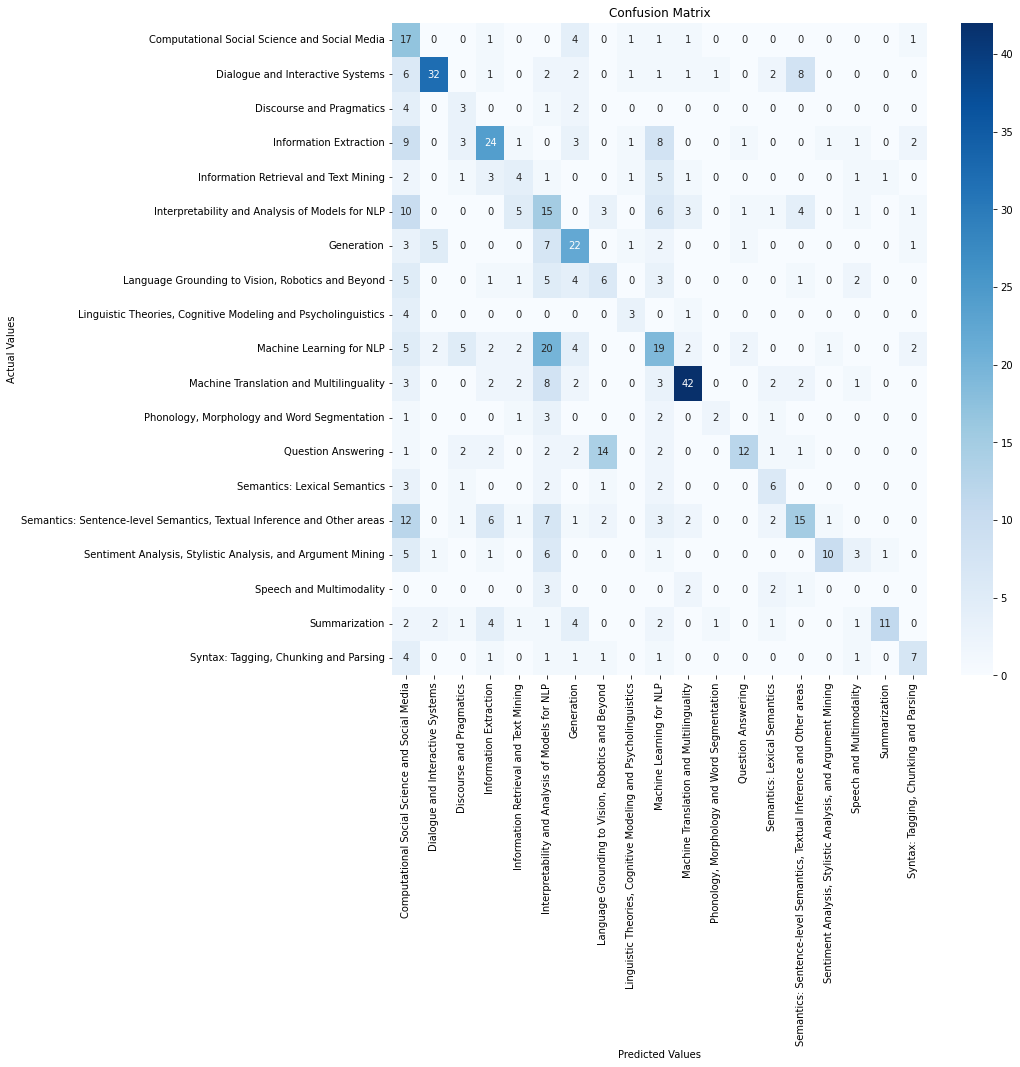

In [1560]:
idx_labels = list(df_test["Label"].unique())

cm = confusion_matrix(df_test['Label'], df_test['Predicted Label'], labels = idx_labels)
cm_df = pd.DataFrame(cm,
                     index = idx_labels, 
                     columns = idx_labels)

#Plotting the confusion matrix
plt.figure(figsize=(12,12))
sns.heatmap(cm_df, annot=True, cmap="Blues")
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

In [1561]:
print(classification_report(df_test['Label'], df_test['Predicted Label']))

                                                                        precision    recall  f1-score   support

                         Computational Social Science and Social Media       0.18      0.61      0.27        28
                                      Dialogue and Interactive Systems       0.76      0.55      0.64        58
                                              Discourse and Pragmatics       0.18      0.27      0.21        11
                                                        Ethics and NLP       0.00      0.00      0.00         0
                                                            Generation       0.43      0.52      0.47        42
                                                Information Extraction       0.50      0.44      0.47        54
                                 Information Retrieval and Text Mining       0.22      0.18      0.20        22
                       Interpretability and Analysis of Models for NLP       0.18      0.29      0.22  

/home/yanxia/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

/home/yanxia/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

/home/yanxia/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.



In [1562]:
df_test_accuracy = df_test_outcome.pivot(index="Label", columns="Label Outcome", values="Counts").reset_index().fillna(0)
df_test_accuracy["Accuracy"] = df_test_accuracy[True] / (df_test_accuracy[False] + df_test_accuracy[True]) * 100
df_test_accuracy = df_test_accuracy.sort_values(by = 'Accuracy', axis=0, ascending=False)
df_test_accuracy

Label Outcome,Label,False,True,Accuracy
10,Machine Translation and Multilinguality,27.0,42.0,60.869565
0,Computational Social Science and Social Media,11.0,17.0,60.714286
1,Dialogue and Interactive Systems,26.0,32.0,55.172414
3,Generation,20.0,22.0,52.380952
4,Information Extraction,30.0,24.0,44.444444
18,"Syntax: Tagging, Chunking and Parsing",10.0,7.0,41.176471
13,Semantics: Lexical Semantics,10.0,6.0,37.500000
15,"Sentiment Analysis, Stylistic Analysis, and Argument Mining",18.0,10.0,35.714286
17,Summarization,20.0,11.0,35.483871
8,"Linguistic Theories, Cognitive Modeling and Psycholinguistics",6.0,3.0,33.333333
